In [95]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import gc
import codecs
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer

%matplotlib inline
%load_ext autotime

pal = sns.color_palette()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 21.1 ms


In [96]:
# Paths

if os.path.isdir('data'):
    QUORA_DATA_DIR = "data/"
    GLOVE_DATA_DIR = "data/"
else:
    QUORA_DATA_DIR = "/opt/datasets/quora/"
    GLOVE_DATA_DIR = ""/opt/datasets/glove/"

TRAIN_CSV = QUORA_DATA_DIR + 'train.csv'
TEST_CSV = QUORA_DATA_DIR + 'test.csv'

glove_840B_300d = GLOVE_DATA_DIR + 'glove.840B.300d.txt'
GLOVE_DATA_FILE = glove_840B_300d

time: 3.56 ms


In [97]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 45
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.01

time: 2.36 ms


# Data Analysis

In [54]:
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)

# Train Data
train_feature_1_string = pd.Series(df_train['question1'].tolist()).astype(str)
train_feature_2_string = pd.Series(df_train['question2'].tolist()).astype(str)

target = pd.Series(df_train['is_duplicate'].tolist())

all_train_qs = train_feature_1_string + train_feature_2_string

# Test Data
test_feature_1_string = pd.Series(df_test['question1'].tolist()).astype(str)
test_feature_2_string = pd.Series(df_test['question2'].tolist()).astype(str)

all_test_qs = test_feature_1_string + test_feature_2_string

all_qs = all_train_qs + all_test_qs

print(all_train_qs.tolist()[:10])

df_train.head()

['What is the step by step guide to invest in share market in india?What is the step by step guide to invest in share market?', 'What is the story of Kohinoor (Koh-i-Noor) Diamond?What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?', 'How can I increase the speed of my internet connection while using a VPN?How can Internet speed be increased by hacking through DNS?', 'Why am I mentally very lonely? How can I solve it?Find the remainder when [math]23^{24}[/math] is divided by 24,23?', 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?Which fish would survive in salt water?', "Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?", 'Should I buy tiago?What keeps childern active and far from phone and video games?', 'How can I be a good geologist?What should I do to be a great geologist?', 'When do you us

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [79]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Text Analysis

In [98]:
dt_all_qids = df_train.qid1 + df_train.qid1

time: 3.51 ms


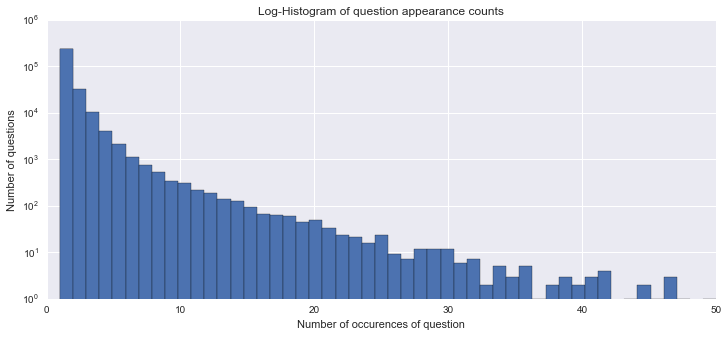

time: 1.24 s


In [99]:
plt.figure(figsize=(12, 5))
plt.hist(dt_all_qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [100]:
all_qids = df_train.qid1 + df_train.qid2

time: 6 ms


In [101]:
train_qs = df_train.question1 + df_train.question2

time: 296 ms


In [106]:
total_ques_pairs = len(df_train)
print('Total number of question pairs for training: {}'.format(total_ques_pairs))

duplicate_ques_pairs = round(df_train['is_duplicate'].mean()*100, 2)
print('Duplicate pairs: {}%'.format(duplicate_ques_pairs))

unique_qids = len(np.unique(train_qs.fillna("")))
print('Total number of questions in the training data: {}'.format(unique_qids))

print('Number of questions that appear multiple times: {}'.format(np.sum(all_qids.value_counts() > 1)))

print("Total number of questions in Quora dataset: {}".format(len(all_qs)))

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 404289
Number of questions that appear multiple times: 50205
Total number of questions in Quora dataset: 2345796
time: 1.04 s


In [107]:

# dist_train = train_qs.apply(len)
# dist_test = test_qs.apply(len)

# plt.figure(figsize=(15, 10))
# plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
# plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
# plt.title('Normalised histogram of character count in questions', fontsize=15)
# plt.legend()
# plt.xlabel('Number of characters', fontsize=15)
# plt.ylabel('Probability', fontsize=15)

# print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f} max-train{:.2f}'.format(dist_train.mean(), 
#                           dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max(), dist_train.max()))

time: 3.02 ms


In [108]:
# from wordcloud import WordCloud
# cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
# plt.figure(figsize=(20, 15))
# plt.imshow(cloud)
# plt.axis('off')

time: 1.57 ms


In [120]:
if ('embeddings_index' not in dir()):
    print('Indexing word vectors.')
    embeddings_index = {}
    with codecs.open(GLOVE_DATA_FILE, encoding='utf-8') as f:
        for line in f:
            # line for '<key> <vector coeffecients>'
            # Example 'A 0.2341 0.12313 0.31432 0.123414 ....'
            values = line.split(' ')
            embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
            break
    print('Found %s word vectors.' % len(embeddings_index))
else:
    print('Skipped to save some time!')

Indexing word vectors.
Found 1 word vectors.
time: 84.8 ms


In [18]:
# embeddings_index['best']

In [27]:
# %%time
# all_questions_text = train_feature_1_text + train_feature_2_text + test_feature_1_text + test_feature_2_text
# all_questions_text = list(filter(lambda q: type(q) == str, all_questions_text))

In [28]:
# ques_lengths = list(map(lambda q: len(str(q).split(' ')) if(type(q) is str) else 0, all_questions_text))
# #Beware the questions has nan and numbers

# print(max(ques_lengths))   

In [ ]:
def getTokenizeModel(list_of_all_string, max_number_words):
    tokenizer = Tokenizer(nb_words = max_number_words)
    tokenizer.fit_on_texts(dt_all_questions_text)

In [33]:
# %time
# tokenizer = Tokenizer(nb_words=dt_MAX_NB_WORDS)
# tokenizer.fit_on_texts(all_questions_text)
# train_sequences_1 = dt_tokenizer.texts_to_sequences(train_feature_1_text)
# train_sequences_2 = dt_tokenizer.texts_to_sequences(train_feature_2_text)
# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

# dt_test_sequences_1 = tokenizer.texts_to_sequences(test_feature_1_text)
# dt_test_sequences_2 = tokenizer.texts_to_sequences(test_feature_2_text)

# data_1 = pad_sequences(train_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
# data_2 = pad_sequences(train_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
# labels = np.array(labels)
# print('Shape of data tensor:', data_1.shape)
# print('Shape of label tensor:', labels.shape)

# test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
# test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
# test_labels = np.array(test_labels)
# del test_sequences_1
# del test_sequences_2
# del train_sequences_1
# del train_sequences_2
# import gc
# gc.collect()

In [2]:
l = ["just say a word","of some length"]
ll = list(map(lambda l: l.split(" "), l))
seq_length = 5
ll
e = {"just": [0,0,0,0,1],
     "say" : [0,0,0,1,1],
     "a" : [0,1,1,1,0],
     "word" : [1,0,0,1,0],
     "of" : [0,1,0,1,0],
     "some" : [0,1,0,1,0],
     "length" : [0,0,1,1,0],
     '<PAD>': [0,0,0,0,0]
    }

In [39]:
# list of words --> lows

from pprint import pprint as pp

def lows_padding(list_of_words, seq_length=5, append=True):
    """Pads/slices given bag of words for specified length."""
    if len(list_of_words) == seq_length:
        return list_of_words
    if len(list_of_words) > seq_length:
        return list_of_words[:seq_length]
    
    tmp = ['<PAD>' for i in range(seq_length - len(list_of_words))]
    if append:
        return list_of_words + tmp
    return  tmp + list_of_words

def lows_embedding(list_of_words, serializer):
    """To serializer/string Tokenize the list of words."""
    return list(map(lambda x: serializer[x], list_of_words))

def lows_transformer(list_of_words, serializer, seq_length, append):
    """To pad the given list of words and serialiase them."""
    return lows_embedding(lows_padding(list_of_words, seq_length, append),
                          serializer=e)

bag_of_lows_transformer = lambda list_of_words: lows_transformer(list_of_words, serializer=e,
                                                                 seq_length=4, append=True)

pp(list(map(bag_of_lows_transformer, ll)))

[[[0, 0, 0, 0, 1], [0, 0, 0, 1, 1], [0, 1, 1, 1, 0], [1, 0, 0, 1, 0]],
 [[0, 1, 0, 1, 0], [0, 1, 0, 1, 0], [0, 0, 1, 1, 0], [0, 0, 0, 0, 0]]]


In [100]:
def get_feature(embed_dict, list_of_strings, max_seq_length, embed_dim):
    features = np.zeros((len(list_of_strings), max_seq_length, embed_dim), dtype=float)
    list_of_bag_of_words = map(lambda l: list_of_words_padding(list_of_words=l.split(),
                                                                seq_length=max_seq_length,
                                                                append=True),
                                list_of_strings)
    return list_of_bag_of_words

    
list(get_feature(e, l, 7, 5))    

[['just', 'say', 'a', 'word', '', '', ''],
 ['of', 'some', 'length', '', '', '', '']]

# Build the Graph

In [70]:
lstm_size = 256
lstm_layers = 1
batch_size = 250
learning_rate = 0.001

In [ ]:
# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, None, None], name='inputs') #[Number of ques, Seq/Ques Length, Embed Dims]
    labels_ = tf.placeholder(tf.float32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

http://suriyadeepan.github.io/2016-06-28-easy-seq2seq/

https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words

https://github.com/yuhaozhang/sentence-convnet

In [46]:
500 / 60

8.333333333333334